# 🦌 RuDOLPH 350M

<b><font color="white" size="+2">Official colab of [RuDOLPH: One Hyper-Modal Transformer can be creative as DALL-E and smart as CLIP](https://github.com/sberbank-ai/ru-dolph)</font></b>


<font color="white" size="-0.75."><b>RuDOLPH</b> is a fast and light text-image-text transformer (350M GPT-3) for generating text like <b>GPT</b>, generating image (e.g.: image by text, image by image prompt) like <b>DALL-E</b>, generating image captions, image classification in Zero-Shot mode and image ranking like <b>CLIP</b>. 

<b>RuDOLPH 350M</b> is designed for quick and easy fine-tuning setup for solution of various tasks: from generating images by text description and image classification, to visual question answering and more. This colab demonstates the power of Hyper-Modal Transfomers.</font>

Hyper-modality means generalized multi-modal, e.g., model that consists of two multi-modal parts: text-2-image and image-2-text becomes text and image hyper-modality model

<font color="white" size="-0.75."><b>RuDOLPH for fast zero-shot text to image generation.</b> On the first phase we generate 288 in 5 min images by text! It takes Diffusion decoder is based on [Jack000](https://github.com/Jack000/) solution and ESRGAN-Real for high quality image rendering.</font>

# install all

In [ ]:
!pip install rudolph==0.0.1rc8 > /dev/null
!pip install bitsandbytes-cuda111 > /dev/null
!pip install wandb > /dev/null
!pip install pytorch-lightning > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#Download data

In [ ]:
!pip install --upgrade gdown

In [ ]:
import gdown

# a file
url = "http://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o"
output = "food.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: http://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o
To: /content/food.zip
100%|██████████| 34.8M/34.8M [00:01<00:00, 26.0MB/s]


'food.zip'

In [ ]:
!unzip /content/food.zip

# Train this deer🦌🦌🦌

In [ ]:
import os
import sys
import random
from collections import Counter

import PIL
import torch
import numpy as np
import pandas as pd
import bitsandbytes as bnb
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from rudalle import get_tokenizer, get_vae
from rudalle.utils import seed_everything
import pytorch_lightning as pl
from rudolph.model.utils import get_attention_mask
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph.pipelines import generate_codebooks, self_reranking_by_image, self_reranking_by_text, show, generate_captions, generate_texts, zs_clf
from rudolph import utils

In [ ]:
device = 'cuda'

model = get_rudolph_model('350M',  fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


In [ ]:
class Args():
    def __init__(self, model):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 5
        self.save_path='checkpoints/'
        self.model_name = 'awesomemodel_'
        self.save_every = 500
        self.bs = 2
        self.clip = 1.0
        self.lr = 2e-5
        self.freeze = False
        self.wandb = False
        self.train_steps = 10
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 1
        self.rt_loss_weight = 7
        self.image_size = self.image_tokens_per_dim * 8

args = Args(model)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, file_path, csv_path, tokenizer, shuffle=True):
        self.tokenizer = tokenizer
        self.samples = []
        self.image_transform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            T.RandomResizedCrop(args.image_size, scale=(1., 1.), ratio=(1., 1.)),
            T.ToTensor()
        ])

        df = pd.read_csv(csv_path)
        df.columns = ['index', 'belok', 'fats', 'uglevod', 'kkal', 'name', 'path']

        for belok, fats, uglevod, kkal, caption, f_path in zip(
            df['belok'],df['fats'], df['uglevod'], df['kkal'], df['name'], df['path']
        ):
            caption = f'блюдо: {caption}; белков: {belok}; жиров: {fats}; углеводов: {uglevod}; ккал: {kkal};'
            if len(caption)>10 and len(caption)<100 and os.path.isfile(f'{file_path}/{f_path}'):
                self.samples.append([file_path, f_path, caption.lower()])
        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')

    def __len__(self):
        return len(self.samples)

    def load_image(self, file_path, img_name):
        return PIL.Image.open(f'{file_path}/{img_name}')

    def __getitem__(self, item):
        item = item % len(self.samples)
        file_path, img_name, text = self.samples[item]

        try:
            image = self.load_image(file_path, img_name)
            image = self.image_transform(image)
        except Exception as err: 
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        
        text = text.lower().strip()
        encoded = self.tokenizer.encode_text(text, text_seq_length=args.r_text_seq_length)       
        return encoded, image

#Lets look what is inside food Dataset 🤔

In [ ]:
dataset = FoodDataset(file_path='/content/food' ,csv_path ='/content/food/food.csv',tokenizer=tokenizer)
args.train_steps = len(dataset)//args.bs

Shuffled


In [ ]:
class FoodDataModule(pl.LightningDataModule):

  def __init__(self, file_path, csv_path, tokenizer):
    super().__init__()
   

  def setup(self, stage=None):
    self.train_dataset = FoodDataset(file_path='/content/food', 
                                     csv_path ='/content/food/food.csv', 
                                     tokenizer=tokenizer)

    

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=args.bs,
      shuffle=True,
      
    )

data_module = FoodDataModule(file_path='/content/food' ,csv_path ='/content/food/food.csv',tokenizer=tokenizer)

In [ ]:
idx = random.randint(0, len(dataset)-1)
encoded, image = dataset[idx]

print(tokenizer.decode_text(encoded))

plt.imshow(image.permute(1,2,0).cpu().numpy());

In [ ]:
idx = random.randint(0, len(dataset)-1)
encoded, image = dataset[idx]

print(tokenizer.decode_text(encoded))

plt.imshow(image.permute(1,2,0).cpu().numpy());

In [ ]:
df = pd.read_csv('/content/food/food.csv')
wc, c = WordCloud(), Counter()

for text in df['name']:
  try:
    c.update(wc.process_text(text))    
  except:
    continue

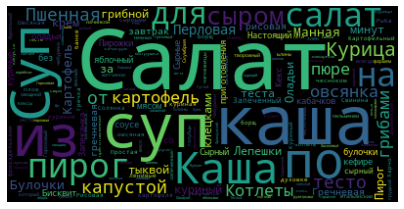

In [ ]:
wc.fit_words(c)
plt.figure(figsize=(7,7));
plt.imshow(wc, interpolation='bilinear');
plt.axis("off");

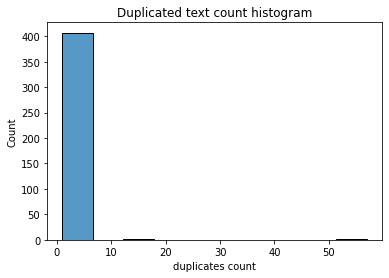

In [ ]:
import seaborn as sns
text_value_counts = pd.DataFrame(df['name'].value_counts())
ax = sns.histplot(data=text_value_counts, x="name");
ax.set_title('Duplicated text count histogram');
ax.set_xlabel('duplicates count');

#Train this deer 🦌🎄☃️

In [ ]:
class Rudolph_(pl.LightningModule):

  def __init__(self, args, vae):
    super().__init__()
    

    self.model = get_rudolph_model('350M',  fp16=False, device=self.device)

    #self.vae = get_vae(dwt=False).to(self.device)

   
    print(self.device)
  
  def forward(self, 
            input_ids,
            lt_loss_weight=0.1,
            img_loss_weight=0.8, 
            rt_loss_weight=0.1,  
            return_loss=True):
   
    total_seq_length = args.l_text_seq_length + args.image_seq_length*args.image_seq_length + args.r_text_seq_length
    masks = torch.ones(args.bs, args.r_text_seq_length, dtype=torch.int32)

    attention_mask = get_attention_mask(masks, args.bs, args.l_text_seq_length, args.image_tokens_per_dim,
                                                    args.r_text_seq_length, self.device)

    loss, loss_values = self.model.forward(input_ids, 
                                           attention_mask, 
                                           lt_loss_weight=lt_loss_weight,
                                           img_loss_weight=img_loss_weight, 
                                           rt_loss_weight=rt_loss_weight, 
                                           return_loss=True)
    
    return loss



  def training_step(self, batch):
    text, images = batch[0], batch[1]
    
    image_input_ids = vae.get_codebook_indices(images).to(self.device)
    r_text = text.to(self.device)
    l_text = torch.zeros((args.bs, args.l_text_seq_length),  dtype=torch.long).to(self.device)

    input_ids = torch.cat((l_text, image_input_ids, r_text), dim=1)
    
    loss = self.forward(input_ids, 
                        lt_loss_weight=args.lt_loss_weight,
                        img_loss_weight=args.img_loss_weight, 
                        rt_loss_weight=args.rt_loss_weight, 
                        return_loss=True)
    
    
    self.log("train_loss", loss, prog_bar=True, logger=True)

    return {"loss": loss}

  def training_epoch_end(self, outputs):
    pass

  def _freeze(self, 
            params,
            freeze_emb=False,
            freeze_ln=False,
            freeze_attn=True,
            freeze_ff=True,
            freeze_other=False):
    #print(params)
    for name, p in enumerate(params):
        #print(name, p)
        #name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model
            




  def configure_optimizers(self):
    if args.freeze:
      optimizer = torch.optim.Adam(self._freeze(self.parameters()), lr=args.lr)

    else:
      optimizer = torch.optim.Adam(self.parameters(), lr=args.lr)
    #bnb.optim.Adam8bit(self.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer, 
      max_lr=args.lr,
      final_div_factor=500, 
      steps_per_epoch=args.train_steps,
      epochs=args.epochs 
    )

    return optimizer
      

In [ ]:
from pytorch_lightning.loggers import WandbLogger
# я использую wandb в качестве логера, если надо замените на тенсорборду
wandb_logger = WandbLogger(project="rudolf")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
 
  mode="min"
)


In [ ]:
model = Rudolph_(args,vae)

data_module = FoodDataModule(file_path='/content/food' ,csv_path ='/content/food/food.csv',tokenizer=tokenizer)

trainer = pl.Trainer(
  logger=wandb_logger,
  checkpoint_callback=checkpoint_callback,
  max_epochs=2,
  accelerator="gpu",
  progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb3f1dea450>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb3f1dea450>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.
cpu


In [ ]:
trainer.fit(model,data_module)

Shuffled


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | ruDolphModel | 353 M 
---------------------------------------
353 M     Trainable params
0         Non-trainable params
353 M     Total params
1,412.260 Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudolph/model/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=device) // self.image_tokens_per_dim


In [ ]:
trainer.save_checkpoint('/rudolf')

# 🖼2✍ Lets test trained model

In [ ]:
def _fix_pl(path):
  d = torch.load(path)["state_dict"]
  checkpoint = {}
  for key in d.keys():
    checkpoint[key.replace('model.','')] = d[key]
  torch.save(checkpoint,'fixed.pt')

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


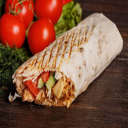

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudolph/model/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=device) // self.image_tokens_per_dim


блюдо: рулет из лаваша ; белков: 1.0; жиров: 2.5; углеводов: 3.8; ккал: 125.4;
блюдо: рулет из лаваша с овощами; белков: 4.7; жиров: 6.7; углеводов: 8.7; ккал: 141.9;
блюдо: хлеб пшеничный с чесноком; белков: 4.0; жиров: 2.0; углеводов: 6.7; ккал: 73.4;
блюдо: рулет из лаваша с курицей, сыром и помидорами; белков: 3.8; жиров: 3.9; углеводов: 9.6; ккал: 95.0;


In [ ]:
template = 'блюдо:'

import requests
from PIL import Image
import torch

device = 'cuda'

model = get_rudolph_model('350M',  fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

# path can change because PL 
_fix_pl('/content/rudolf/1033wc66/checkpoints/epoch=1-step=474-v1.ckpt')

model.load_state_dict(torch.load('fixed.pt'))

img_by_url = 'https://kulinarenok.ru/img/steps/31445/1-7.jpg' #@param {type:"string"}
# img_by_url = 'https://img.delo-vcusa.ru/2020/11/Borshh-s-yablokami.jpg' 

img_by_url = Image.open(requests.get(img_by_url, stream=True).raw).resize((128, 128))
#@markdown number of images
captions_num = 4 #@param{type:'slider'}
display(img_by_url)

texts = generate_captions(img_by_url, tokenizer, model, vae, template=template, 
                          top_k=16, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img_by_url, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])